In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import torch
from torchvision.transforms.functional import to_tensor
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# [ FM2-V160-000 : Left Side ]

In [2]:
def load_images_to_tensor(directory, image_size=(224, 224), transform=None, device='cpu'):
    """
    지정된 디렉토리 내의 모든 이미지를 불러와 하나의 텐서로 변환합니다.

    Parameters:
    - directory (str): 이미지 파일이 있는 디렉토리의 경로
    - image_size (tuple): 모든 이미지를 조정할 크기 (width, height). 기본값은 (224, 224)
    - transform (torchvision.transforms.Compose): 추가적인 이미지 전처리 변환. 기본값은 None
    - device (str): 텐서를 저장할 디바이스 ('cpu' 또는 'cuda'). 기본값은 'cpu'

    Returns:
    - torch.Tensor: 모든 이미지를 포함하는 텐서 (N, C, H, W)
    """
    # 기본 이미지 전처리 변환 정의
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            # 필요에 따라 추가적인 변환을 여기에 추가할 수 있습니다.
            # 예: transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                        std=[0.229, 0.224, 0.225]),
        ])
    
    # 인식할 이미지 파일 확장자 목록
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')
    
    # 디렉토리가 존재하는지 확인
    if not os.path.isdir(directory):
        raise ValueError(f"디렉토리 '{directory}'가 존재하지 않습니다.")
    
    # 디렉토리 내 모든 파일 목록 가져오기
    files = os.listdir(directory)
    image_files = [file for file in files if file.lower().endswith(image_extensions)]
    
    if len(image_files) == 0:
        raise ValueError(f"디렉토리 '{directory}'에 이미지 파일이 없습니다.")
    
    # 모든 이미지를 저장할 리스트 초기화
    image_tensors = []
    
    # tqdm을 사용하여 진행 상황 표시
    for img_file in tqdm(image_files, desc="Loading images"):
        img_path = os.path.join(directory, img_file)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # RGB로 변환 (필요에 따라 다른 모드 사용 가능)
                img_tensor = transform(img)
                image_tensors.append(img_tensor)
        except Exception as e:
            print(f"이미지 '{img_path}'를 불러오는 중 오류가 발생했습니다: {e}")
    
    if len(image_tensors) == 0:
        raise ValueError(f"유효한 이미지 파일을 하나도 불러올 수 없습니다.")
    
    # 모든 이미지 텐서를 하나의 텐서로 스택
    all_images_tensor = torch.stack(image_tensors).to(device)
    
    return all_images_tensor


In [3]:
def visualize_image_from_tensor(tensor, n):
    """
    텐서에서 n번째 샘플을 시각화합니다.

    Parameters:
    - tensor (torch.Tensor): 불러온 이미지 텐서 (N, C, H, W)
    - n (int): 시각화할 샘플의 인덱스 (0부터 시작)

    Raises:
    - ValueError: n이 텐서 범위를 벗어날 경우
    """
    if n < 0 or n >= tensor.size(0):
        raise ValueError(f"인덱스 {n}는 텐서 범위 [0, {tensor.size(0)-1}]를 벗어났습니다.")
    
    # n번째 샘플 추출
    image_tensor = tensor[n]
    
    # 텐서를 numpy 배열로 변환 (H, W, C)
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    
    # 값의 범위를 0-1로 정규화
    if image_np.max() > 1:
        image_np = image_np / 255.0  # 정규화
    
    # 시각화
    plt.imshow(image_np, aspect='equal')  # 가로 세로 비율을 유지
    plt.axis('off')  # 축 제거
    plt.title(f"No. {n}", fontsize=16)
    plt.show()

In [4]:
def template_matching_and_crop(master, left_image):
    # OpenCV 포맷으로 변환
    master_np = master.permute(1, 2, 0).numpy()  # (3, H, W) -> (H, W, 3)
    left_image_np = left_image.permute(1, 2, 0).numpy()

    # OpenCV 템플릿 매칭
    result = cv2.matchTemplate(left_image_np, master_np, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    top_left = max_loc  # 최고 매칭 위치

    # 매칭된 영역을 crop
    h, w = master_np.shape[:2]
    cropped = left_image_np[top_left[1]:top_left[1] + h, top_left[0]:top_left[0] + w]

    # 488x488 크기 보장
    cropped = cv2.resize(cropped, (488, 488))  # 필요시 resize
    cropped_tensor = to_tensor(cropped)  # Tensor로 변환
    return cropped_tensor

- Pass Data

In [5]:
directory_path_left = './plus_data_sep/FM2-V160-000/LEFT'  # 실제 디렉토리 경로로 변경하세요.

# 이미지 개수를 세는 함수와 함께 텐서 로딩 함수 사용
left_images = load_images_to_tensor(
    directory=directory_path_left,
    image_size=(800, 1280),
    transform=None,
    device='cpu'
)

print(f"모든 이미지를 포함하는 텐서의 형태: {left_images.shape}")

Loading images: 100%|██████████| 3962/3962 [00:51<00:00, 77.04it/s] 


모든 이미지를 포함하는 텐서의 형태: torch.Size([3962, 3, 800, 1280])


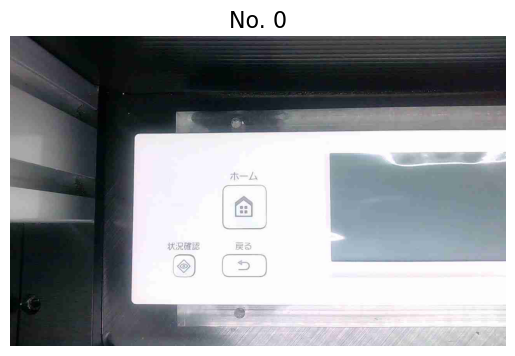

In [6]:
n = 0
visualize_image_from_tensor(left_images, n)

# Cropped images with Template matching

- Pass Data

In [7]:
# master 이미지 로드
master_image_path = "./cropped_data_dohun/cropped_data/master/FM2-V160_master.jpeg"
master = cv2.imread(master_image_path, cv2.IMREAD_COLOR)
master = cv2.cvtColor(master, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 읽으므로 RGB로 변환
master = cv2.resize(master, (488, 488))  # master 이미지 크기 확인 및 변환
master_tensor = to_tensor(master)  # Tensor로 변환 (3, 488, 488)

# 템플릿 매칭 및 크롭 실행
cropped_images = []
for i in range(left_images.shape[0]):
    cropped = template_matching_and_crop(master_tensor, left_images[i])
    cropped_images.append(cropped)

# 결과를 텐서로 병합
# (n, 3, 488, 488)
cropped_left_images = torch.stack(cropped_images)

# 5. 결과 저장 또는 활용
print(f"Final cropped images tensor shape: {cropped_left_images.shape}")

Final cropped images tensor shape: torch.Size([3962, 3, 488, 488])


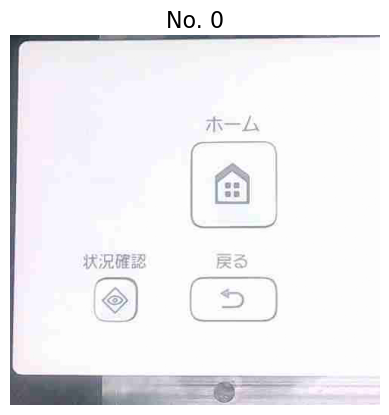

In [8]:
visualize_image_from_tensor(cropped_left_images, n)